<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Comparing-Activation-Functions-using-Linear-Classifier-(MLP-Network)-on-Fashion-MNIST-dataset" data-toc-modified-id="Comparing-Activation-Functions-using-Linear-Classifier-(MLP-Network)-on-Fashion-MNIST-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparing Activation Functions using Linear Classifier (MLP Network) on Fashion MNIST dataset</a></span><ul class="toc-item"><li><span><a href="#Dataset-Download-Commands" data-toc-modified-id="Dataset-Download-Commands-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dataset Download Commands</a></span></li><li><span><a href="#Function-that-Loads-Dataset" data-toc-modified-id="Function-that-Loads-Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Function that Loads Dataset</a></span></li><li><span><a href="#Dataset-Class,-Network-Class,-Train-and-Evaluation-Function" data-toc-modified-id="Dataset-Class,-Network-Class,-Train-and-Evaluation-Function-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Dataset Class, Network Class, Train and Evaluation Function</a></span></li><li><span><a href="#Main-Function-using-Linear-Model-with-Sigmoid-and-Training-the-Model-with-Cross-Validation" data-toc-modified-id="Main-Function-using-Linear-Model-with-Sigmoid-and-Training-the-Model-with-Cross-Validation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Main Function using Linear Model with Sigmoid and Training the Model with Cross Validation</a></span></li><li><span><a href="#Experiment:-Comparing-Activation-Functions" data-toc-modified-id="Experiment:-Comparing-Activation-Functions-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Experiment: Comparing Activation Functions</a></span></li><li><span><a href="#Visualizing-the-Results" data-toc-modified-id="Visualizing-the-Results-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Visualizing the Results</a></span></li></ul></li></ul></div>

# Comparing Activation Functions using Linear Classifier (MLP Network) on Fashion MNIST dataset

Elif Cansu YILDIZ

## Dataset Download Commands

In [5]:
# Note: Forwarded stderr to /dev/null so no output will be shown but it works! :)
!wget -O train-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz 2> /dev/null
!wget -O train-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz 2> /dev/null
!wget -O t10k-images-idx3-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz 2> /dev/null
!wget -O t10k-labels-idx1-ubyte.gz http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz 2> /dev/null

In [ ]:
# -*- coding: utf-8 -*-
import os
import gzip
import torch as th
import numpy as np
import matplotlib.pyplot as plt

## Function that Loads Dataset

In [6]:
def load_mnist(dataset="training", path="."):
    if dataset not in  ['training', 'testing']:
        raise ValueError("dataset has to be either 'training' or 'testing'")

    if dataset == 'training':
        kind = 'train'
    else:
        kind = 't10k'

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8).astype(np.float32)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28).astype(np.float32)

    return th.from_numpy(images), th.from_numpy(labels)

## Dataset Class, Network Class, Train and Evaluation Function

In [15]:
import torch as th

class DatasetFashion():
    def __init__(self, option, classes = range(10), sortd=False, crossvalidation=None, path='./', split_mode=0):
        X,y = load_mnist(option, path)

        self.images = X.reshape([-1, 28*28])
        self.images = self.images/255.0
        self.labels = y.type(th.long) 

        #shuffling
        indices = th.randperm(len(self.labels))
        self.images = self.images[indices]
        self.labels = self.labels[indices]
   
        #eliminating unwanted classes and sorting at the same time
        #indices = th.cat([th.nonzero(self.labels == i) for i in classes], dim=0)
        #self.images = self.images[indices]
        #self.labels = self.labels[indices]
          
        if crossvalidation:
            splitSize = len(self.labels)//crossvalidation[0]
            chunks = th.split(th.arange(len(self.labels)), splitSize, dim=0)
            validation = chunks[crossvalidation[1]]
            training = th.cat([c for j, c in enumerate(chunks) if j!=crossvalidation[1]], dim=0)
            self.validationImages = self.images[validation]
            self.validationLabels = self.labels[validation]
            self.trainingImages = self.images[training]
            self.trainingLabels = self.labels[training]

        else:
            if split_mode==0:

                # shuffle the data before splitting
                indices = th.randperm(len(self.labels))
                self.images = self.images[indices]
                self.labels = self.labels[indices]

                #split the data
                split_ratio = int(len(self.images)*4/5)

                self.trainingImages = self.images[:split_ratio]
                self.trainingLabels = self.labels[:split_ratio]
                self.validationImages = self.images[split_ratio:]
                self.validationLabels = self.labels[split_ratio:]

            else:

                self.trainingImages = th.tensor([])
                self.trainingLabels = th.tensor([], dtype=th.long)
                self.validationImages = th.tensor([])
                self.validationLabels = th.tensor([], dtype=th.long)

                for i in classes:
                    indices = self.labels==i
                    images_i = self.images[indices, :]
                    labels_i = self.labels[indices]
                    split_ratio = int(len(images_i)*4/5)
                    self.trainingImages = th.cat((self.trainingImages, images_i[:split_ratio]), dim=0)
                    self.trainingLabels = th.cat((self.trainingLabels, labels_i[:split_ratio]), dim=0)
                    self.validationImages = th.cat((self.validationImages, images_i[split_ratio:]), dim=0)
                    self.validationLabels = th.cat((self.validationLabels, labels_i[split_ratio:]), dim=0)

        if sortd:
            indices = th.argsort(self.trainingLabels.squeeze())
            self.trainingImages = self.trainingImages[indices]
            self.trainingLabels = self.trainingLabels[indices]


    def __len__(self):
        return len(self.trainingLabels)

    def __getitem__(self, index):
        return self.trainingImages[index], self.trainingLabels[index]
            
class Network(th.nn.Module):
    def __init__(self, num_inputs, num_classes, num_neurons=(50,20), activation=th.nn.ReLU):
        super(Network, self).__init__()
        self.activation = activation
        self.logsoftmax = th.nn.LogSoftmax(dim=1)
        
        self.layers = th.nn.ModuleList()
        self.layers.append(th.nn.Linear(num_inputs, num_neurons[0], True))
        for i in range(len(num_neurons)-1):
            self.layers.append(th.nn.Linear(num_neurons[i], num_neurons[i+1], True))
        self.layers.append(th.nn.Linear(num_neurons[-1], num_classes, True))
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.logsoftmax(self.layers[-1](x))
    
def train(model, dataloader, optimizer):
    
    loss_hist = np.array([])
    for index, (trainingImages,trainingLabels) in enumerate(dataloader):
        optimizer.zero_grad()
        prediction = model(trainingImages.squeeze())
        loss = th.nn.functional.nll_loss(prediction, trainingLabels.squeeze())
        loss_hist = np.append(loss_hist, loss.item())
        loss.backward()
        optimizer.step()
        with th.no_grad():
            if index % 100 == 0:
                print('Train {}/{} Loss {:.6f}'.format(index, len(dataloader), loss.item()))
    return loss_hist
                
def evaluate(model, images, labels):
    prediction = model(images.squeeze())
    loss = th.nn.functional.nll_loss(prediction, labels.squeeze())
    pred_label = th.argmax(prediction, dim=1)
    #print("----------", pred_label[0:10], labels.squeeze()[0:10], pred_label[0:10] == labels.squeeze()[0:10])
    accuracy = ((pred_label == labels.squeeze()).sum().item()) / len(images)
    #accuracy = th.sum(pred_label == labels.squeeze()) / len(labels)
    return loss, accuracy


# x * sigmoid(beta*x)
class Swish(th.nn.Module):
    def __init__(self, beta):
        #th.nn.Parameter
        self.beta = th.tensor([beta])
        
    def forward(self, x):
        return x * th.sigmoid(self.beta*x)

## Main Function using Linear Model with Sigmoid and Training the Model with Cross Validation

In [16]:
if __name__ == "__main__":
    
    model = Network(28*28, 10, activation = th.sigmoid)
    optimizer = th.optim.SGD(model.parameters(), lr=0.01)

    training_loss_hist = np.array([])
    valid_loss_hist = np.array([])
    valid_acc_hist = np.array([])
    avg_loss = 0.0
    for i in range(5):
        print("Validation", " fold: ", i+1)
        dataset = DatasetFashion("training", crossvalidation=(5,i))
        dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

        for epoch in range(10):
            print("Epoch ", epoch)
            #training
            loss_hist_per_epoch = train(model, dataloader, optimizer)

            #evaluate every epoch
            valid_loss, valid_accuracy = evaluate(model, dataset.validationImages, dataset.validationLabels)
            
            #loss and accuracy histories are kept
            training_loss_hist = np.hstack((training_loss_hist, loss_hist_per_epoch))
            valid_loss_hist = np.hstack((valid_loss_hist, valid_loss.item()))   #item is used to get just number instead of tensor. Otherwise, it raises error
            valid_acc_hist = np.hstack((valid_acc_hist, valid_accuracy))
            print("validation loss = ", valid_loss.item(), " accuracy = ", valid_accuracy)

        #evaluation after training
        valid_loss, valid_accuracy = evaluate(model, dataset.validationImages, dataset.validationLabels)
        avg_loss += valid_loss/5
   
    print("Average Loss", avg_loss)

Validation   fold:  1
Epoch  0
Train 0/750 Loss 2.347773
Train 100/750 Loss 2.320921
Train 200/750 Loss 2.304821
Train 300/750 Loss 2.293862
Train 400/750 Loss 2.300738
Train 500/750 Loss 2.296592
Train 600/750 Loss 2.293603
Train 700/750 Loss 2.296427
validation loss =  2.294604539871216  accuracy =  0.09508333333333334
Epoch  1
Train 0/750 Loss 2.292259
Train 100/750 Loss 2.297479
Train 200/750 Loss 2.291737
Train 300/750 Loss 2.288614
Train 400/750 Loss 2.291019
Train 500/750 Loss 2.286469
Train 600/750 Loss 2.286533
Train 700/750 Loss 2.281460
validation loss =  2.280086040496826  accuracy =  0.24733333333333332
Epoch  2
Train 0/750 Loss 2.279157
Train 100/750 Loss 2.277470
Train 200/750 Loss 2.270855
Train 300/750 Loss 2.283481
Train 400/750 Loss 2.273291
Train 500/750 Loss 2.260312
Train 600/750 Loss 2.261028
Train 700/750 Loss 2.252024
validation loss =  2.2501883506774902  accuracy =  0.222
Epoch  3
Train 0/750 Loss 2.253121
Train 100/750 Loss 2.244649
Train 200/750 Loss 2.2401

Text(0.5, 1.0, 'validation accuracy history')

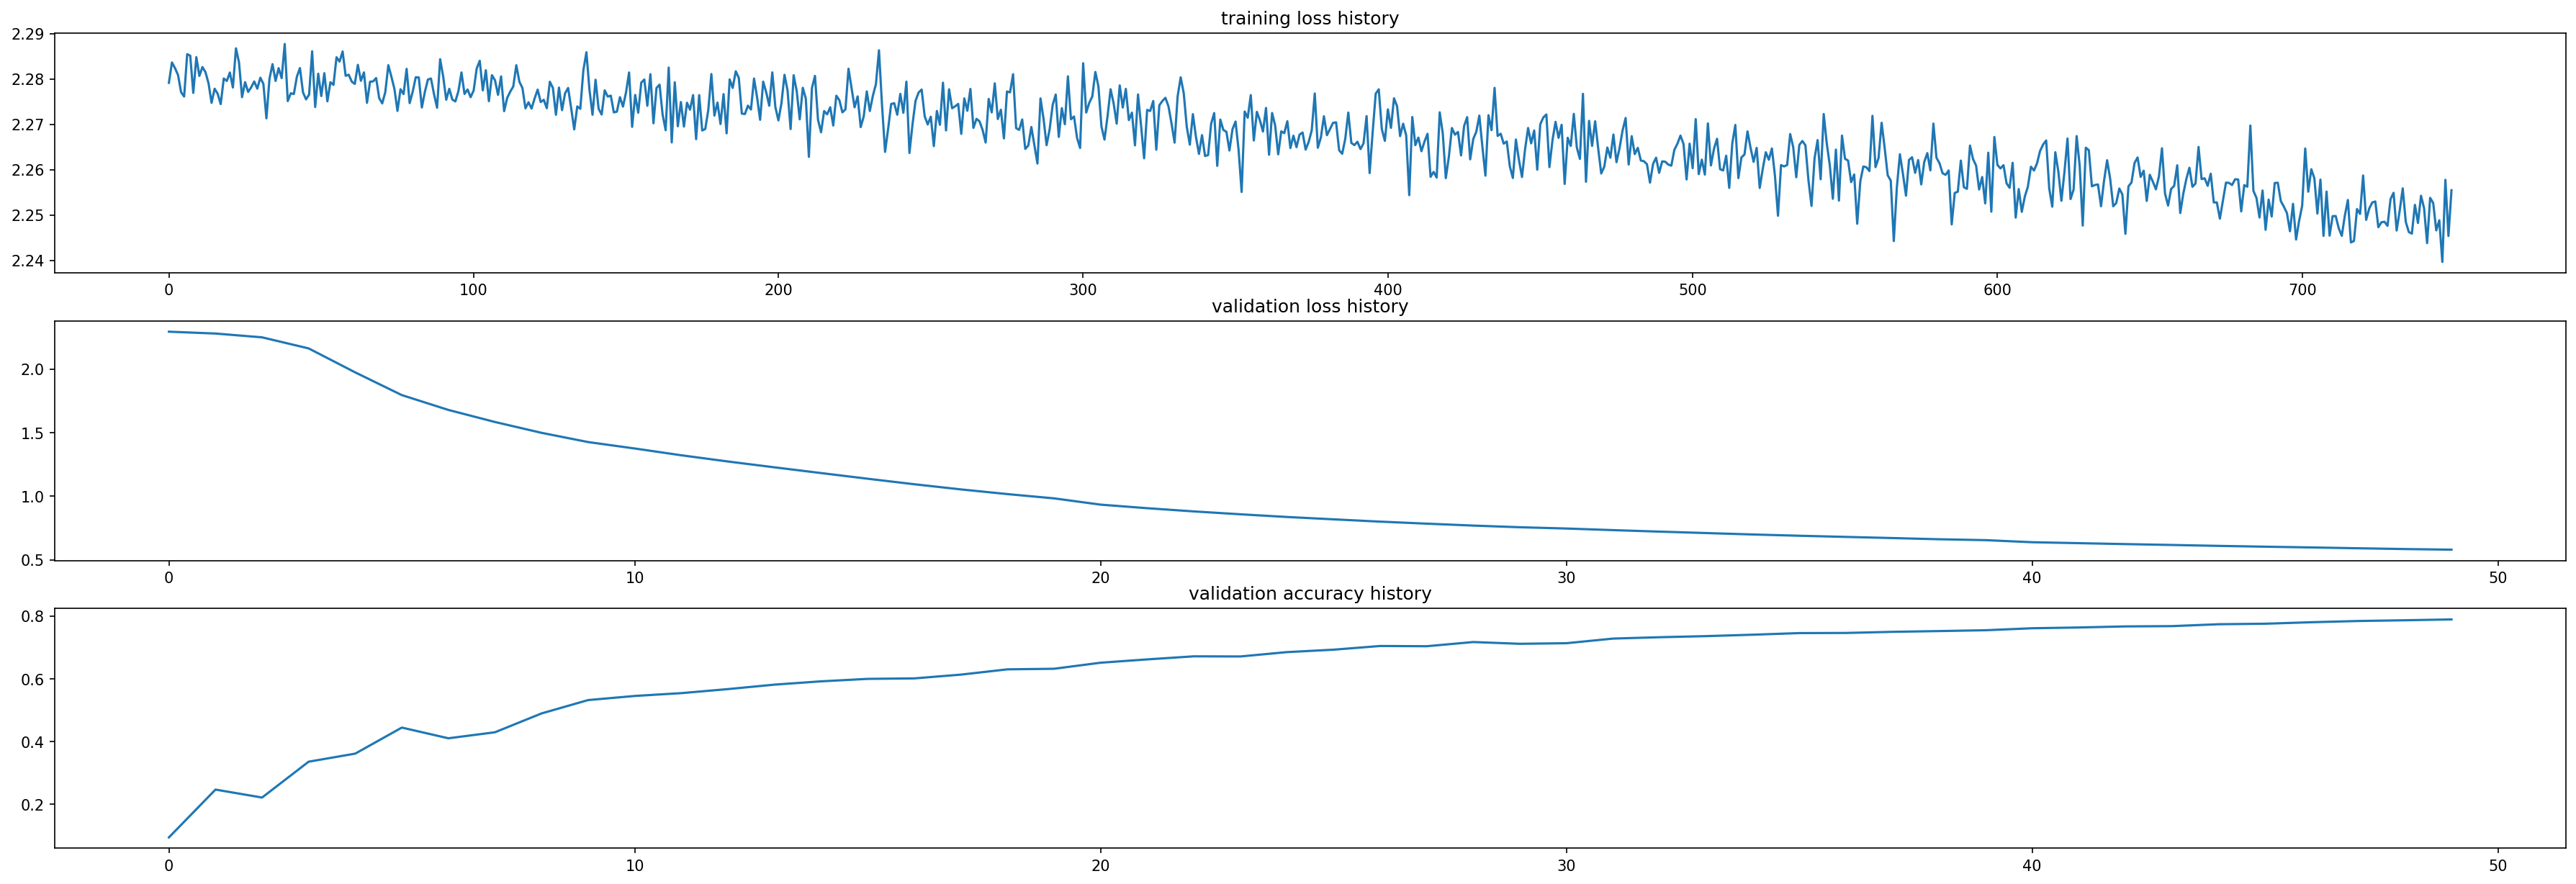

In [17]:
fig, axs = plt.subplots(3, figsize=(30,10), dpi=150, sharex=False, sharey=False)

epoch = 2   #which epoch loss data you want to visualize
num_of_batch = 750
axs[0].plot(training_loss_hist[epoch*num_of_batch : (epoch+1)*num_of_batch], "-"); axs[0].set_title('training loss history')
axs[1].plot(valid_loss_hist); axs[1].set_title('validation loss history')
axs[2].plot(valid_acc_hist); axs[2].set_title('validation accuracy history')

## Experiment: Comparing Activation Functions

Run a 5-fold cross-validation for the following activation functions:
- identity function (no special activation)
- Tanh
- Sigmoid
- ReLu
- Leaky ReLu  

All of these functions are available as a torch.nn.Module in the torch.nn package.    
To speed up convergence, you should be able to run 10 epochs per split with a
learning rate of 0.01

In [37]:
if __name__ == "__main__":
    
    activations = [th.sigmoid, th.relu, th.tanh]
    
    act_training_loss_hist = []
    act_valid_loss_hist = []
    act_valid_acc_hist = []
    act_avg_loss = []

    for act in activations:
        print("Activation function:", act)
        model = Network(28*28, 10, activation = act)
        optimizer = th.optim.SGD(model.parameters(), lr=0.01)

        training_loss_hist = np.array([])
        valid_loss_hist = np.array([])
        valid_acc_hist = np.array([])
        avg_loss = 0.0

        for i in range(5):
            print("Validation", " fold: ", i+1)
            dataset = DatasetFashion("training", crossvalidation=(5,i))
            dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

            for epoch in range(10):
                print("Epoch ", epoch)
                #training
                loss_hist_per_epoch = train(model, dataloader, optimizer)

                #evaluate every epoch
                valid_loss, valid_accuracy = evaluate(model, dataset.validationImages, dataset.validationLabels)
                
                #loss and accuracy histories are kept
                training_loss_hist = np.hstack((training_loss_hist, loss_hist_per_epoch))
                valid_loss_hist = np.hstack((valid_loss_hist, valid_loss.item()))   #item is used to get just number instead of tensor. Otherwise, it raises error
                valid_acc_hist = np.hstack((valid_acc_hist, valid_accuracy))
                print("validation loss = ", valid_loss.item(), " accuracy = ", valid_accuracy)

            #evaluation after training
            valid_loss, valid_accuracy = evaluate(model, dataset.validationImages, dataset.validationLabels)
            avg_loss += valid_loss.item()/5

        act_training_loss_hist.append(training_loss_hist)
        act_valid_loss_hist.append(valid_loss_hist)
        act_valid_acc_hist.append(valid_acc_hist)
        act_avg_loss.append(avg_loss)
          
    print("Average Loss", avg_loss)

Activation function: <built-in method sigmoid of type object at 0x7ff8a42ecca0>
Validation  fold:  1
Epoch  0
Train 0/750 Loss 2.394457
Train 100/750 Loss 2.317396
Train 200/750 Loss 2.287286
Train 300/750 Loss 2.298468
Train 400/750 Loss 2.297154
Train 500/750 Loss 2.297959
Train 600/750 Loss 2.298603
Train 700/750 Loss 2.294618
validation loss =  2.2949557304382324  accuracy =  0.19975
Epoch  1
Train 0/750 Loss 2.299291
Train 100/750 Loss 2.294850
Train 200/750 Loss 2.291213
Train 300/750 Loss 2.291574
Train 400/750 Loss 2.290392
Train 500/750 Loss 2.283340
Train 600/750 Loss 2.279809
Train 700/750 Loss 2.281826
validation loss =  2.2808825969696045  accuracy =  0.341
Epoch  2
Train 0/750 Loss 2.281699
Train 100/750 Loss 2.273309
Train 200/750 Loss 2.274298
Train 300/750 Loss 2.268628
Train 400/750 Loss 2.271539
Train 500/750 Loss 2.262794
Train 600/750 Loss 2.265709
Train 700/750 Loss 2.262017
validation loss =  2.2513060569763184  accuracy =  0.3705
Epoch  3
Train 0/750 Loss 2.2535

## Visualizing the Results

Text(0.5, 1.0, 'tanh validation accuracy history')

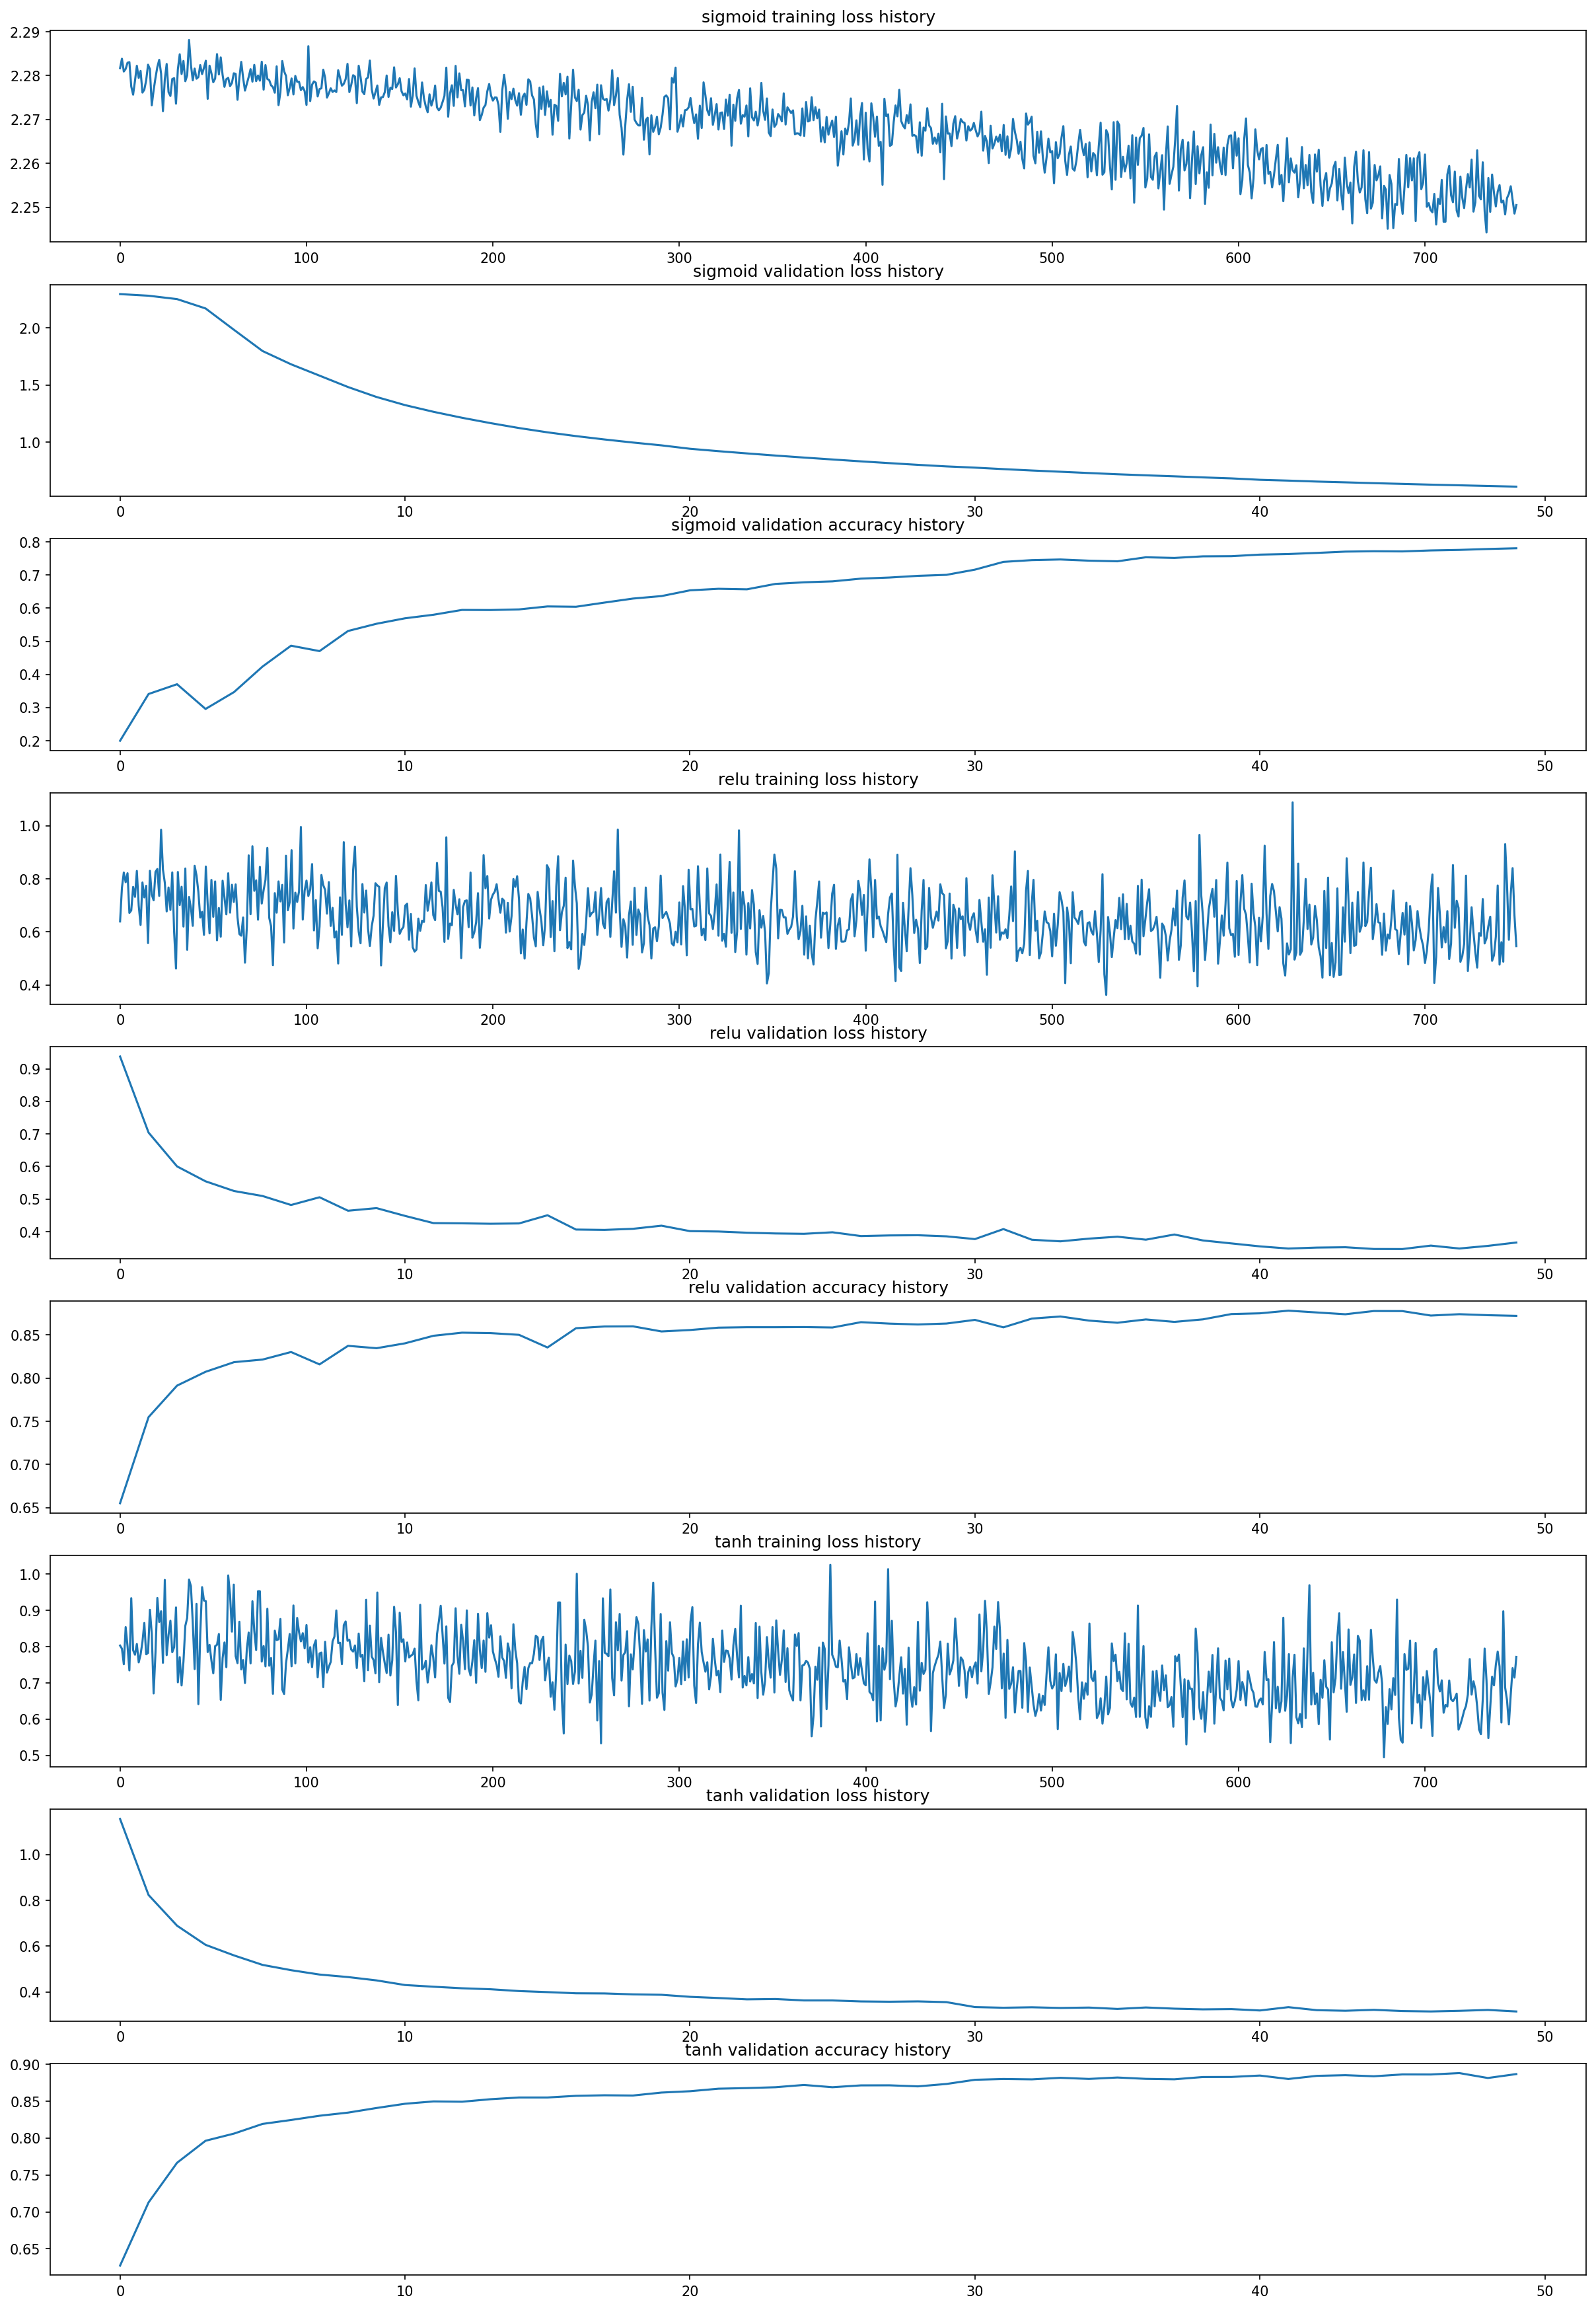

In [41]:
fig, axs = plt.subplots(9, figsize=(20,30), dpi=150, sharex=False, sharey=False)

epoch = 2   #which epoch loss data you want to visualize
num_of_batch = 750
axs[0].plot(act_training_loss_hist[0][epoch*num_of_batch : (epoch+1)*num_of_batch], "-"); axs[0].set_title('sigmoid training loss history')
axs[1].plot(act_valid_loss_hist[0]); axs[1].set_title('sigmoid validation loss history')
axs[2].plot(act_valid_acc_hist[0]); axs[2].set_title('sigmoid validation accuracy history')

axs[3].plot(act_training_loss_hist[1][epoch*num_of_batch : (epoch+1)*num_of_batch], "-"); axs[3].set_title('relu training loss history')
axs[4].plot(act_valid_loss_hist[1]); axs[4].set_title('relu validation loss history')
axs[5].plot(act_valid_acc_hist[1]); axs[5].set_title('relu validation accuracy history')

axs[6].plot(act_training_loss_hist[2][epoch*num_of_batch : (epoch+1)*num_of_batch], "-"); axs[6].set_title('tanh training loss history')
axs[7].plot(act_valid_loss_hist[2]); axs[7].set_title('tanh validation loss history')
axs[8].plot(act_valid_acc_hist[2]); axs[8].set_title('tanh validation accuracy history')